<h1 style="font-family: Trebuchet MS; font-size: 14px; color: #720026; text-align: right; ">Matthew Liew</h1>
<h1><br><span style="color: #720026;; font-size: 30px"><b>Entrix: Case Study Challenge</b></span><br></h1>

In [39]:
# load necessary packages

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import data_utils as du
import plotters
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.utils.statistics import (
    check_seasonality, plot_acf, plot_pacf, remove_seasonality,remove_trend,
    stationarity_test_adf
)   
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.model_selection import train_test_split
import os
from meteostat import Point, Hourly
import holidays
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from forecast_utils import ARIMAWrapper, XGBWrapper, ProphetWrapper
import yfinance as yf
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from prophet import Prophet
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# To keep track of the RSME and MAE metrics
forecast_metric_long = {}
forecast_metric_short = {}



<a id="0"></a>
<p style="background-color:#ff7f51;font-family:Trebuchet MS;font-weight:bold;color:#FFFFFF ;font-size:40px;text-align:center;border-radius:100px 100px">Question 1</p>



In [40]:
# load data set

day_price_df = pd.read_csv('./data/Day-ahead_Prices_60min.csv')

# split the date column into start and end time, we will use start time only
day_price_df[['start_time', 'end_time']] = day_price_df['MTU (CET/CEST)']\
                                                .str.split(' - ', expand=True)

# drops unnecessary columns
day_price_df.drop(columns=['MTU (CET/CEST)', 'BZN|DE-LU', 'Currency', 'end_time']
                , inplace=True) # assumes all currency same in same region

day_price_df.rename(columns={
    'Day-ahead Price [EUR/MWh]': 'price'
}, inplace=True)

day_price_df['start_time'] = pd.to_datetime(day_price_df['start_time'],
                                            format='%d.%m.%Y %H:%M')
day_price_ts = day_price_df.set_index('start_time') 

px.line(day_price_ts, title='Day-Ahead Price Time Series (EUR/MWh) - hourly')

<a id="0"></a>

# <h1 style="font-family: Trebuchet MS; font-size: 25px; color: #da627d; text-align: left; "><b>Data Cleaning</b></h1>

In this section, we'll focus on data cleaning, specifically checking for any NaN values. If any are found, we'll examine the corresponding dates and determine whether we can fill the missing value using interpolation, back fill or front fill.

In [41]:
idx_nan = day_price_df['price'].isna()
print(f"There exists {idx_nan.sum()} missing values")

# prints missing value with 5 rows before and after
day_price_df[idx_nan]
missing_row = du.show_nrows_around_target(day_price_df, 'price')
missing_row = pd.DataFrame(missing_row).set_index('start_time')
px.line(missing_row, title="Shows missing value(s)")

There exists 1 missing values


We identified one missing value occurring at 2AM CET. Given the time, it's unlikely to be an outlier or exhibit extreme variation, so it's reasonable to interpolate this value.


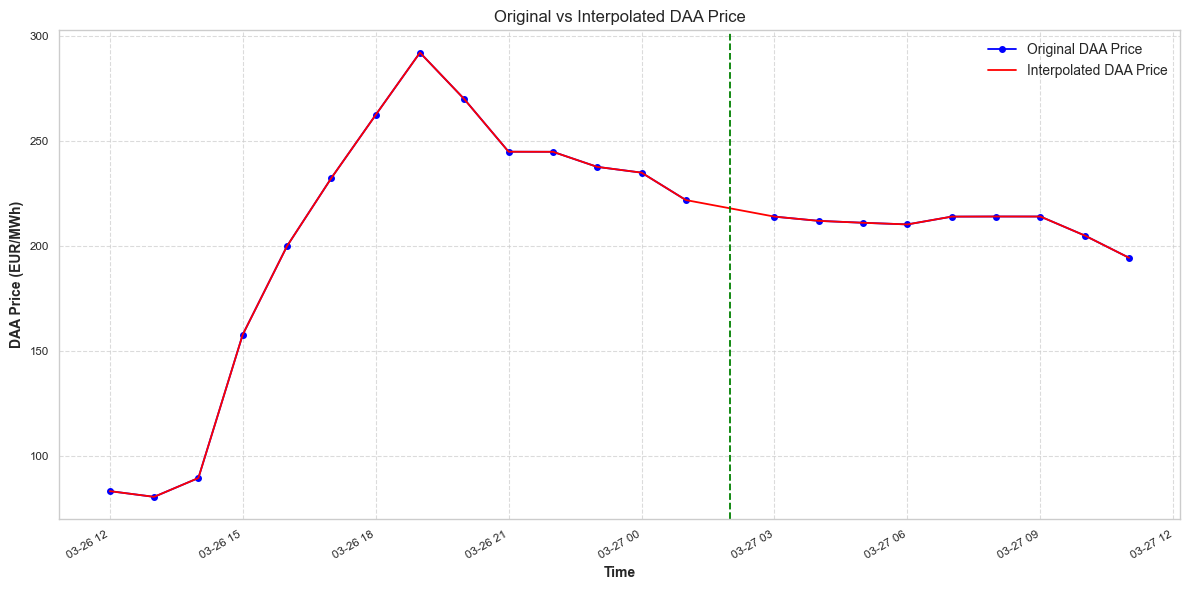

In [42]:
day_price_ts['price_interpolated'] = day_price_ts['price'].interpolate(method='time')

# Analysis
start_date = datetime(2022, 3, 26, 12)
end_date = datetime(2022, 3, 27, 12)
filtered_data = day_price_ts[['price', 'price_interpolated']].loc[
    (day_price_ts.index >= start_date) & (day_price_ts.index < end_date)
]
plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index, filtered_data['price'], 'b-o', label='Original DAA Price', markersize=4)
plt.plot(filtered_data.index, filtered_data['price_interpolated'], 'r-', label='Interpolated DAA Price')
plt.title('Original vs Interpolated DAA Price')
plt.xlabel('Time')
plt.ylabel('DAA Price (EUR/MWh)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

vertical_line_time = datetime(2022, 3, 27, 2)  # Time for the vertical line
plt.axvline(x=vertical_line_time, color='green', linestyle='--', label='02:00')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show();

In [43]:
# replaces interpolated price with original price
day_price_ts['price'] = day_price_ts['price_interpolated']
day_price_ts.drop(columns=['price_interpolated'], inplace=True)
day_price_ts.head()

price
start_time                
2022-01-01 00:00:00  50.05
2022-01-01 01:00:00  41.33
2022-01-01 02:00:00  43.22
2022-01-01 03:00:00  45.46
2022-01-01 04:00:00  37.67

<a id="0"></a>

# <h1 style="font-family: Trebuchet MS; font-size: 25px; color: #da627d; text-align: left; "><b>Preliminary Analysis</b></h1>

Now that we have a complete time series dataset, we can perform a preliminary analysis to inspect the time series data

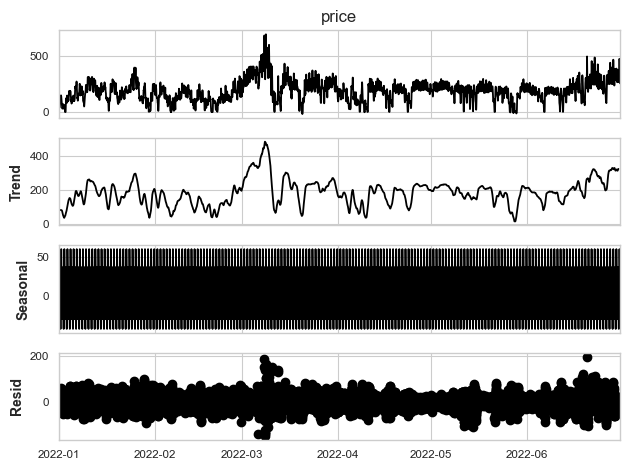

In [44]:
# Seasonal decomposition

seasonal_decompose(day_price_ts['price']).plot()
plt.show()

The seasonal decomposition of the price time series reveals a clear upward trend with a noticeable disturbance around early March 2022, this is likely caused by **Russia invasion of Ukraine**. Furthermore, towards the end, there appears to be slight upward trend.

The seasonal component shows regular periodic behavior, likely due to daily or hourly cycles. 

The residuals remain relatively stable throughout most of the period, there is increased variability and notable outliers around the same March period, aligning with the observed spike.

This suggests that perhaps one may use ARIMA or ETS to model the time series.

<a id="0"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">ARIMA</p>

#TODO

Stationarity test for whole series with 0 lag:
Reject the null hypothesis. The series is likely stationary.

Train-Test split at 2022-06-01 00:00:00
Stationarity test for train series with 0 lag:
Reject the null hypothesis. The series is likely stationary.



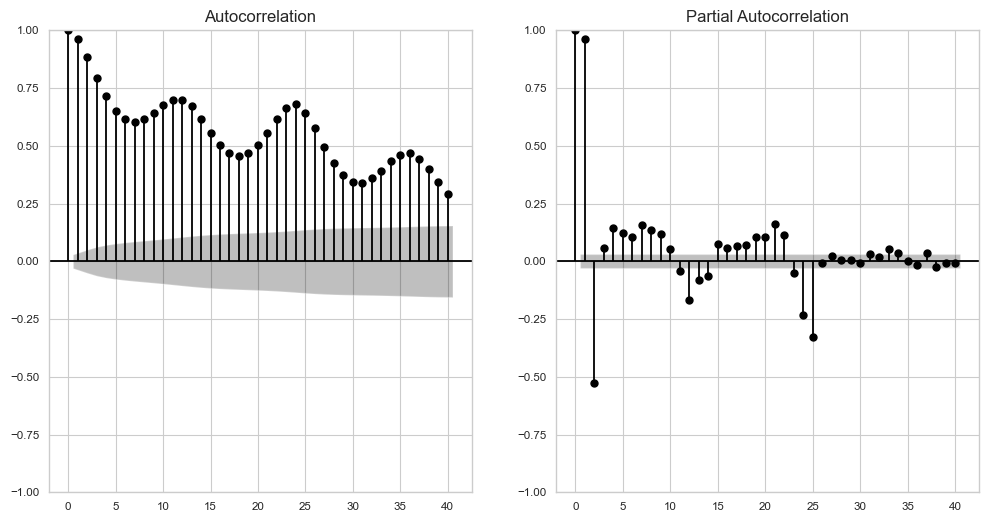

In [45]:
split_date = datetime(2022, 6, 1)
arima_obj = ARIMAWrapper(day_price_ts, split_date)
arima_obj.plot_acf_pacf()

### Note:

we find the best (p,d,q) parameters for ARIMA using the training data. We do this by traversing (p,d,q) with different integers and get the one with the smalles AIC value.

In [46]:
# %%capture 
# p,d,q = arima_obj.get_best_ARIMA_params()
# print(f"Best params obtain: ARIMA({p}, {d}, {q})")

# # Best params obtain: ARIMA(5, 1, 3)

In [47]:
arima_obj.run_ARIMA(5, 1, 3)
arima_obj.get_forecast()
arima_obj.plot_forecast()
forecast_metric_long['ARIMA'] = list(arima_obj.get_rmse_mae())

--------------------------------
Running ARIMA(5, 1, 3) on train set


/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum 

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 3625
Model:                 ARIMA(5, 1, 3)   Log Likelihood              -15734.424
Date:                Fri, 16 May 2025   AIC                          31486.848
Time:                        18:42:19   BIC                          31542.606
Sample:                    01-01-2022   HQIC                         31506.712
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0839      0.088     12.258      0.000       0.911       1.257
ar.L2          0.3083      0.180      1.715      0.086      -0.044       0.661
ar.L3         -1.1098      0.145     -7.635      0.0

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



RSME for ARIMA(5, 1, 3): 80.867
MAE for ARIMA(5, 1, 3): 65.13


### Note

From the analysis above, it is clear that ARIMA is not able to forecast too far in advance. Therefore, a smart thing to do is to shorten the forecast period as well as the start datetime of the training set.

In the following, we only want to forecast **24 H** on the day of 30. June 2022 and we take the training from 60 days prior for training.

Stationarity test for whole series with 0 lag:
Reject the null hypothesis. The series is likely stationary.

Train-Test split at 2022-06-29 23:00:00
Stationarity test for train series with 0 lag:
Reject the null hypothesis. The series is likely stationary.



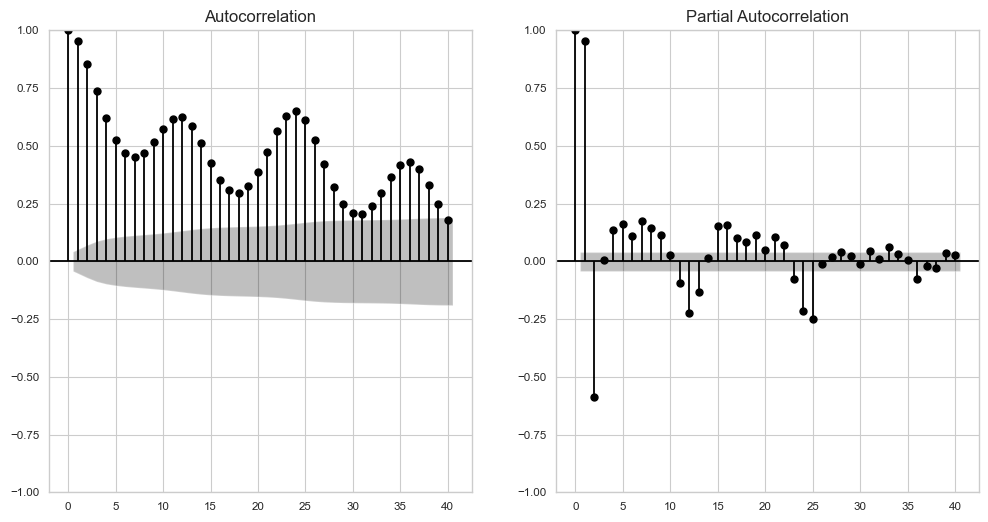

In [48]:
short_split_date = datetime(2022, 6, 29, 23) 
start_slice = split_date - timedelta(days=60) 

short_arima = ARIMAWrapper(day_price_ts, short_split_date, start_date_slice=start_slice)
short_arima.plot_acf_pacf()

In [49]:
# check stationary test for one lag

ts_short = TimeSeries.from_dataframe(short_arima.ts)
ts_train_short = TimeSeries.from_dataframe(short_arima.ts_train)

print(stationarity_test_adf(ts_short, 1))
print("--"*20)
print(stationarity_test_adf(ts_train_short, 1))

# So we should take d = 1

(np.float64(-13.969798268748555), np.float64(4.3660887578948263e-26), 1, 2158, {'1%': np.float64(-3.4333838718977896), '5%': np.float64(-2.8628802551435264), '10%': np.float64(-2.567483485481099)}, np.float64(18841.985495389694))
----------------------------------------
(np.float64(-14.02407015178803), np.float64(3.529014542476664e-26), 1, 2134, {'1%': np.float64(-3.433418033468612), '5%': np.float64(-2.862895338734693), '10%': np.float64(-2.567491516545175)}, np.float64(18586.923040349237))


In [50]:
# %%capture 
# p,d,q = short_arima.get_best_ARIMA_params()

# print(f"Best params obtain: ARIMA({p}, {d}, {q})")

# # Best params obtain: ARIMA(3, 1, 4)

In [51]:
short_arima.run_ARIMA(3, 1, 4)
short_arima.get_forecast()
short_arima.plot_forecast()
forecast_metric_short['ARIMA'] = list(short_arima.get_rmse_mae())

--------------------------------
Running ARIMA(3, 1, 4) on train set


/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2136
Model:                 ARIMA(3, 1, 4)   Log Likelihood               -9030.666
Date:                Fri, 16 May 2025   AIC                          18077.333
Time:                        18:42:22   BIC                          18122.662
Sample:                    04-02-2022   HQIC                         18093.922
                         - 06-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7415      0.044     16.724      0.000       0.655       0.828
ar.L2          0.7156      0.077      9.321      0.000       0.565       0.866
ar.L3         -0.9905      0.044    -22.344      0.0

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



RSME for ARIMA(3, 1, 4): 68.445
MAE for ARIMA(3, 1, 4): 57.871


#### Backtesting (not implemented, no time)

<a id="0"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Prophet</p>

give overview here #TODO

In [52]:
# Reuse the data and split_date from ARIMA for longer window forecast

prophet_obj = ProphetWrapper(
                day_price_ts,
                split_date,
                )
prophet_obj.run_prophet()
prophet_forecast = prophet_obj.get_forecast()

18:42:23 - cmdstanpy - INFO - Chain [1] start processing


Train-Test split at 2022-06-01 00:00:00


18:42:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted. Use get_forecast() to get forecast.


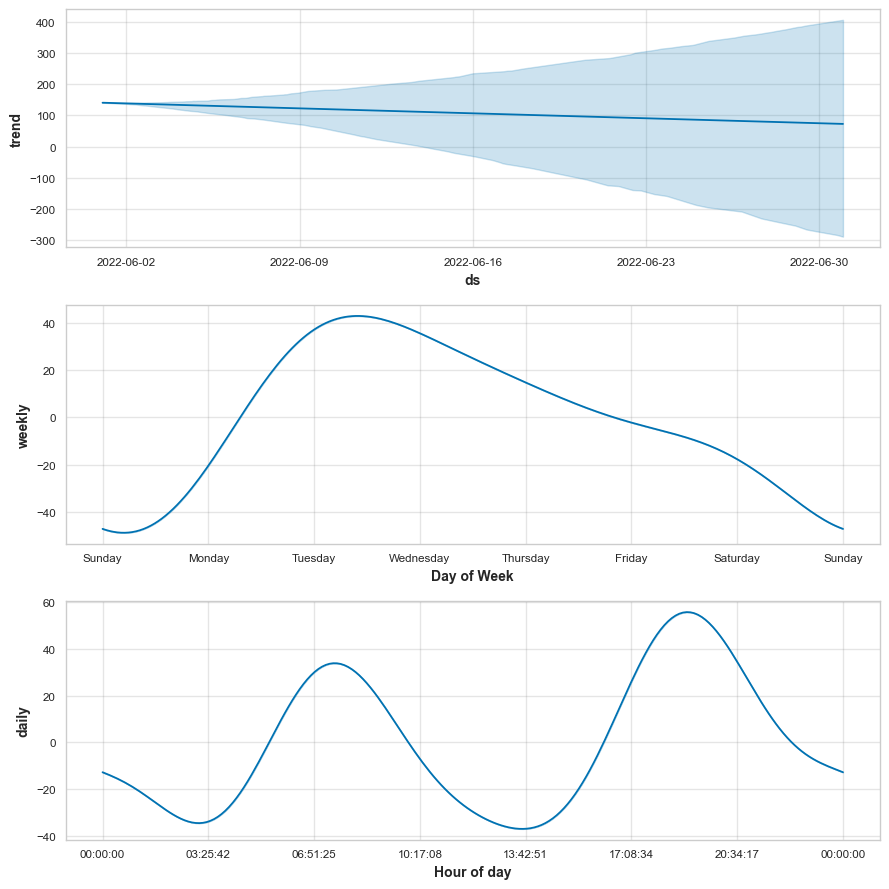

In [53]:
prophet_obj.prophet_model.plot_components(prophet_forecast)
plt.show()
prophet_obj.plot_forecast()

In [54]:
forecast_metric_long['Prophet'] = list(prophet_obj.get_rmse_mae())

RSME for Prophet: 139.455
MAE for Prophet: 114.839


#### **Shorter training window and forecast only 24 H**

18:42:24 - cmdstanpy - INFO - Chain [1] start processing
18:42:24 - cmdstanpy - INFO - Chain [1] done processing


Train-Test split at 2022-06-29 23:00:00
Prophet model fitted. Use get_forecast() to get forecast.


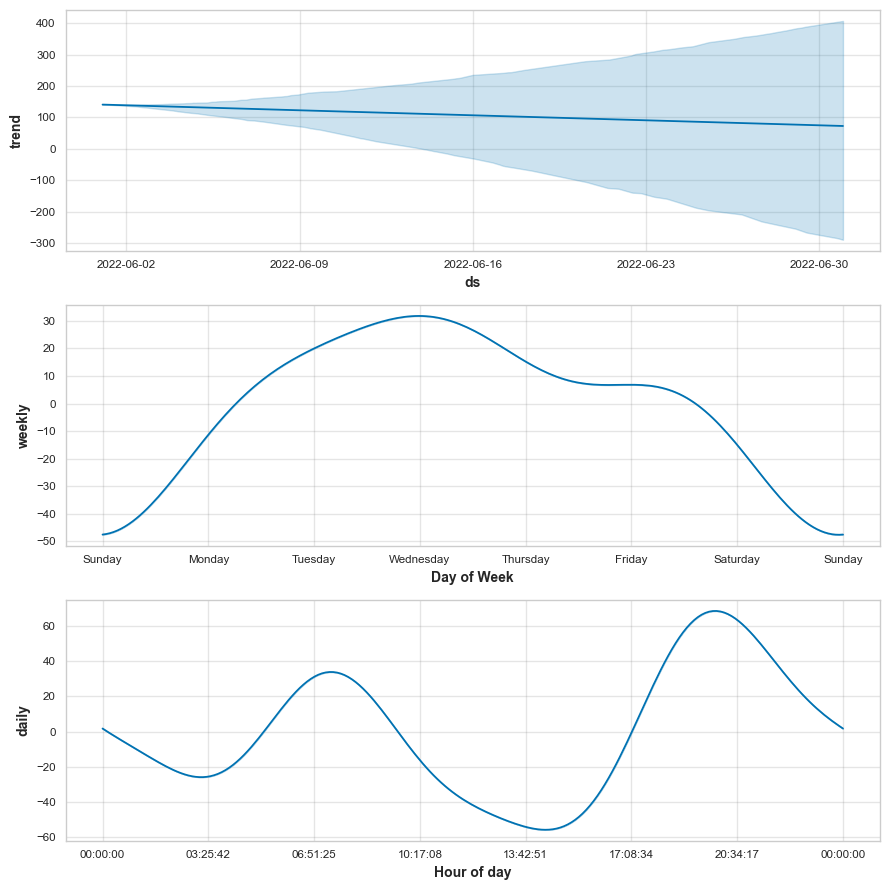

In [55]:
short_date_24H = datetime(2022, 6, 29, 23)
start_slice = split_date - timedelta(days=60) 

short_prophet_obj = ProphetWrapper(
                day_price_ts,
                short_split_date,
                start_date_slice=start_slice
                )
short_prophet_obj.run_prophet()
short_prophet_forecast = short_prophet_obj.get_forecast()
short_prophet_obj.prophet_model.plot_components(prophet_forecast)
plt.show()
short_prophet_obj.plot_forecast()

In [56]:
print("RSME and MAE for short term Prophet:")
forecast_metric_short['Prophet'] = list(short_prophet_obj.get_rmse_mae())

RSME and MAE for short term Prophet:
RSME for Prophet: 39.688
MAE for Prophet: 30.529


<a id="0"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">XGBoost</p>

give overview here #TODO

<a id="0"></a>

## <span style="color: #F8766D;">**Feature Selection**</span>


We loaded an hourly time-series with DAA price per MWh. We start feature engineering by separating the the datetime into its atomic metrics, i.e. month of the year, week of the year, day of the week, and the hour of day. On top of that, we will also extract boolean features such as is_weekend, is_holiday.

We will do this by calling `add_date_features()` function. 

In [57]:
xgb_day_price_ts = du.add_date_features(day_price_ts.copy())

xgb_day_price_ts.head()

price  is_weekend            datetime  hour  dayofweek  \
start_time                                                                    
2022-01-01 00:00:00  50.05        True 2022-01-01 00:00:00     0          5   
2022-01-01 01:00:00  41.33        True 2022-01-01 01:00:00     1          5   
2022-01-01 02:00:00  43.22        True 2022-01-01 02:00:00     2          5   
2022-01-01 03:00:00  45.46        True 2022-01-01 03:00:00     3          5   
2022-01-01 04:00:00  37.67        True 2022-01-01 04:00:00     4          5   

                     quarter  year  dayofyear  dayofmonth  month  weekofyear  \
start_time                                                                     
2022-01-01 00:00:00        1  2022          1           1      1          52   
2022-01-01 01:00:00        1  2022          1           1      1          52   
2022-01-01 02:00:00        1  2022          1           1      1          52   
2022-01-01 03:00:00        1  2022          1           1      1          52   
2022-01-01 04:00:00        1  2022          1           1      1          52   

                     is_holiday  
start_time                       
2022-01-01 00:00:00       False  
2022-01-01 01:00:00       False  
2022-01-01 02:00:00       False  
2022-01-01 03:00:00       False  
2022-01-01 04:00:00       False

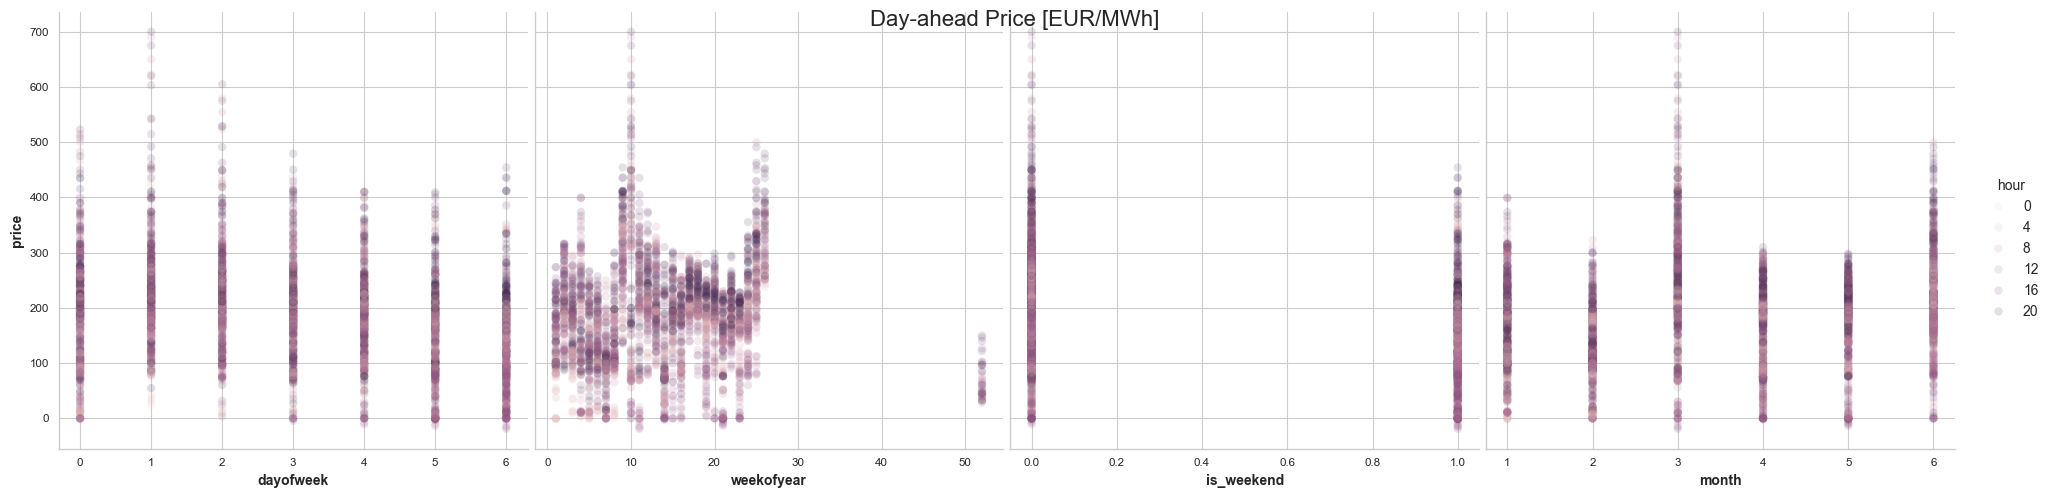

In [58]:
sns.pairplot(xgb_day_price_ts,
            hue='hour',
            x_vars=['dayofweek','weekofyear', 'is_weekend', 'month'],
            y_vars='price',
            height=5,
            plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Day-ahead Price [EUR/MWh]', fontsize=16)
plt.show()

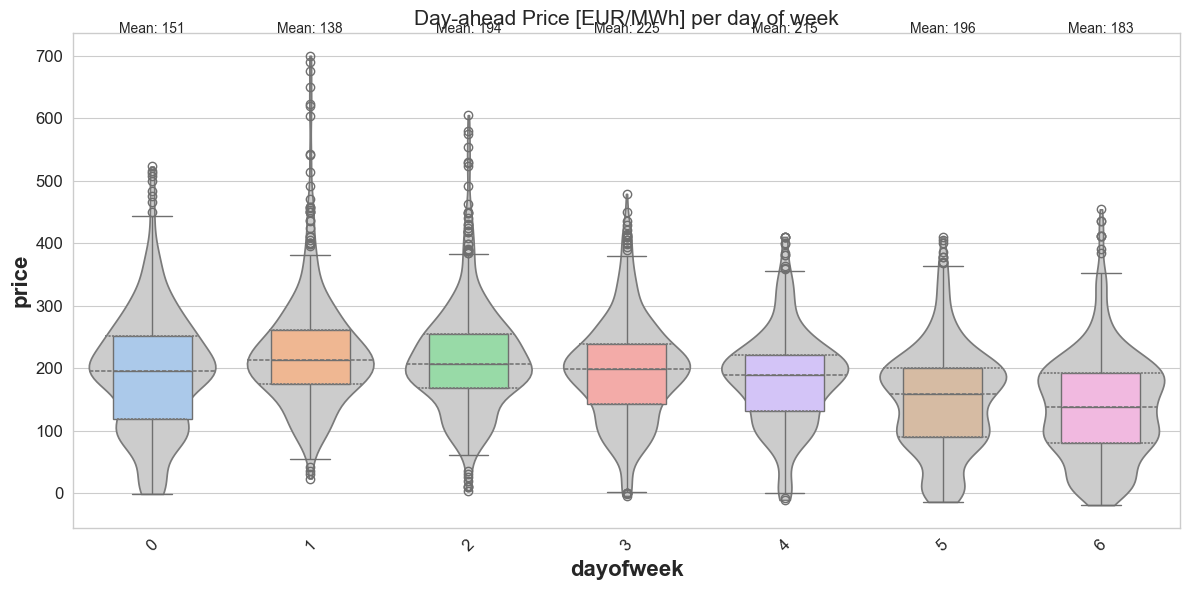

In [59]:
plotters.plot_violin_ts(xgb_day_price_ts, 'dayofweek', 'price', 'Day-ahead Price [EUR/MWh] per day of week')

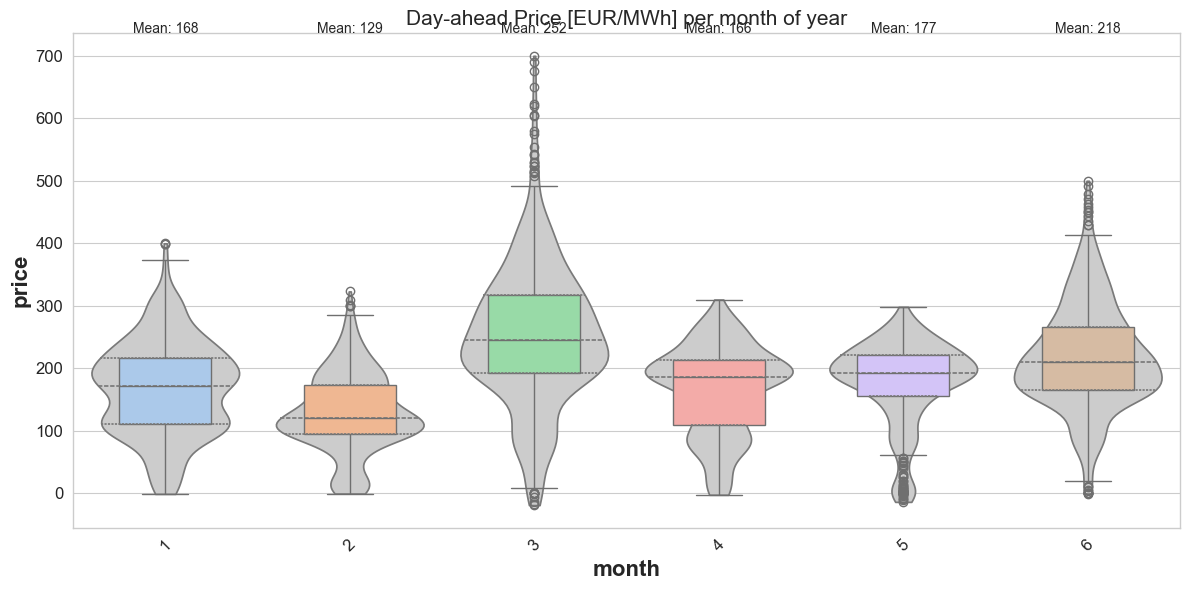

In [60]:
plotters.plot_violin_ts(xgb_day_price_ts, 'month', 'price', 'Day-ahead Price [EUR/MWh] per month of year')

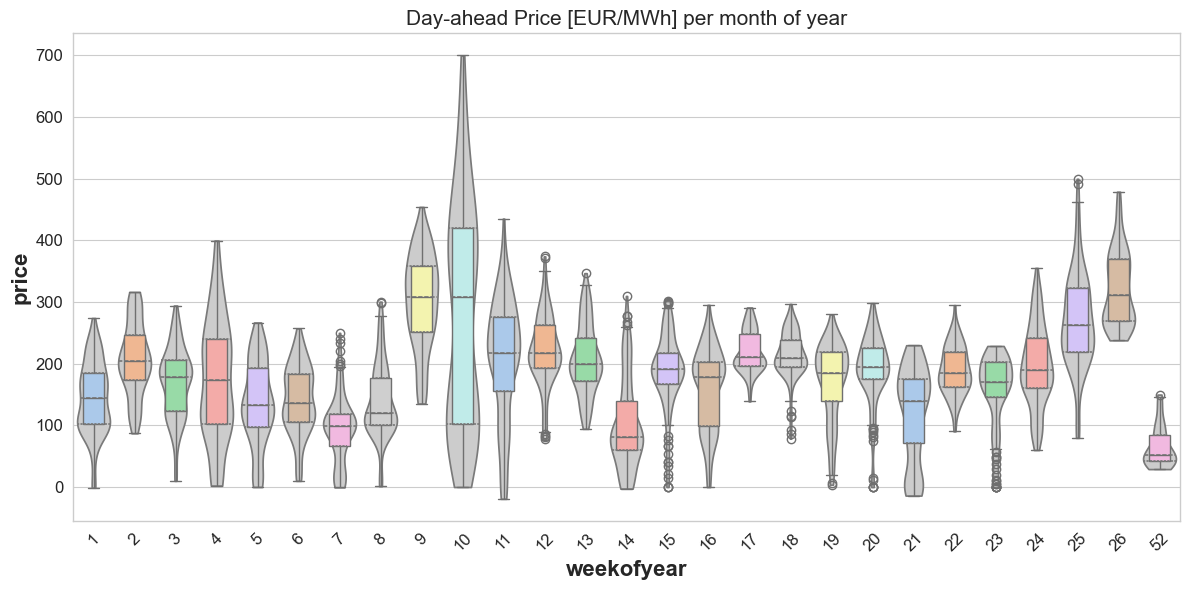

In [61]:
plotters.plot_violin_ts(xgb_day_price_ts, 'weekofyear', 'price', 'Day-ahead Price [EUR/MWh] per month of year', False)

### <span style="color: #F8766D;">**Weather Data**</span>

bla bla

In [62]:
locations = {
    'LU': (49.815273, 6.129583),  # Luxembourg City coordinates
    'DE': (52.520008, 13.404954)  # Berlin coordinates (as an example for Germany)
}
weather_data = du.add_locations_weather(xgb_day_price_ts, locations)

xgb_merged_data = xgb_day_price_ts.merge(weather_data[['temp', 'tsun']], left_index=True, right_index=True, how='left')

xgb_merged_data.head()

price  is_weekend            datetime  hour  dayofweek  \
start_time                                                                    
2022-01-01 00:00:00  50.05        True 2022-01-01 00:00:00     0          5   
2022-01-01 01:00:00  41.33        True 2022-01-01 01:00:00     1          5   
2022-01-01 02:00:00  43.22        True 2022-01-01 02:00:00     2          5   
2022-01-01 03:00:00  45.46        True 2022-01-01 03:00:00     3          5   
2022-01-01 04:00:00  37.67        True 2022-01-01 04:00:00     4          5   

                     quarter  year  dayofyear  dayofmonth  month  weekofyear  \
start_time                                                                     
2022-01-01 00:00:00        1  2022          1           1      1          52   
2022-01-01 01:00:00        1  2022          1           1      1          52   
2022-01-01 02:00:00        1  2022          1           1      1          52   
2022-01-01 03:00:00        1  2022          1           1      1          52   
2022-01-01 04:00:00        1  2022          1           1      1          52   

                     is_holiday  temp  tsun  
start_time                                   
2022-01-01 00:00:00       False  11.9   0.0  
2022-01-01 01:00:00       False  11.9   0.0  
2022-01-01 02:00:00       False  11.9   0.0  
2022-01-01 03:00:00       False  11.9   0.0  
2022-01-01 04:00:00       False  11.8   0.0

### <span style="color: #F8766D;">**How to capture economic sentiment?**</span>

bla bla

In [63]:
indices = ['^VIX', '^GDAXI', 'EURUSD=X']

vix_close = yf.download('^VIX', start=xgb_merged_data.index.min(), end=xgb_merged_data.index.max())['Open']
dax_close = yf.download('^GDAXI', start=xgb_merged_data.index.min(), end=xgb_merged_data.index.max())['Open']
eur_usd_close = yf.download("EURUSD=X", start=xgb_merged_data.index.min(), end=xgb_merged_data.index.max())['Open']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [64]:
xgb_merged_data.head()

price  is_weekend            datetime  hour  dayofweek  \
start_time                                                                    
2022-01-01 00:00:00  50.05        True 2022-01-01 00:00:00     0          5   
2022-01-01 01:00:00  41.33        True 2022-01-01 01:00:00     1          5   
2022-01-01 02:00:00  43.22        True 2022-01-01 02:00:00     2          5   
2022-01-01 03:00:00  45.46        True 2022-01-01 03:00:00     3          5   
2022-01-01 04:00:00  37.67        True 2022-01-01 04:00:00     4          5   

                     quarter  year  dayofyear  dayofmonth  month  weekofyear  \
start_time                                                                     
2022-01-01 00:00:00        1  2022          1           1      1          52   
2022-01-01 01:00:00        1  2022          1           1      1          52   
2022-01-01 02:00:00        1  2022          1           1      1          52   
2022-01-01 03:00:00        1  2022          1           1      1          52   
2022-01-01 04:00:00        1  2022          1           1      1          52   

                     is_holiday  temp  tsun  
start_time                                   
2022-01-01 00:00:00       False  11.9   0.0  
2022-01-01 01:00:00       False  11.9   0.0  
2022-01-01 02:00:00       False  11.9   0.0  
2022-01-01 03:00:00       False  11.9   0.0  
2022-01-01 04:00:00       False  11.8   0.0

In [65]:
xgb_merged_data['date'] = xgb_merged_data['datetime'].dt.date

vix_close['date'] = vix_close.index.date
dax_close['date'] = dax_close.index.date
eur_usd_close['date'] = eur_usd_close.index.date

xgb_merged_data = xgb_merged_data.merge(
                                vix_close[['date', '^VIX']], 
                                on='date', 
                                how='left'
                                )

xgb_merged_data = xgb_merged_data.merge(
                                dax_close[['date', '^GDAXI']], 
                                on='date', 
                                how='left'
                                )

xgb_merged_data = xgb_merged_data.merge(
                                eur_usd_close[['date', 'EURUSD=X']], 
                                on='date', 
                                how='left'
                                )

xgb_merged_data.set_index(xgb_merged_data['date'], inplace=True)

xgb_merged_data = xgb_merged_data.rename(
                                        columns={'^VIX': 'VIX',
                                        '^GDAXI': 'DAX',
                                        'EURUSD=X': 'EURUSD'}
                                        )


xgb_merged_data.drop(['date'], axis=1, inplace=True)
xgb_merged_data = xgb_merged_data.set_index(xgb_merged_data['datetime'])
xgb_merged_data

price  is_weekend            datetime  hour  dayofweek  \
datetime                                                                       
2022-01-01 00:00:00   50.05        True 2022-01-01 00:00:00     0          5   
2022-01-01 01:00:00   41.33        True 2022-01-01 01:00:00     1          5   
2022-01-01 02:00:00   43.22        True 2022-01-01 02:00:00     2          5   
2022-01-01 03:00:00   45.46        True 2022-01-01 03:00:00     3          5   
2022-01-01 04:00:00   37.67        True 2022-01-01 04:00:00     4          5   
...                     ...         ...                 ...   ...        ...   
2022-06-30 19:00:00  479.00       False 2022-06-30 19:00:00    19          3   
2022-06-30 20:00:00  450.00       False 2022-06-30 20:00:00    20          3   
2022-06-30 21:00:00  394.21       False 2022-06-30 21:00:00    21          3   
2022-06-30 22:00:00  355.17       False 2022-06-30 22:00:00    22          3   
2022-06-30 23:00:00  258.08       False 2022-06-30 23:00:00    23          3   

                     quarter  year  dayofyear  dayofmonth  month  weekofyear  \
datetime                                                                       
2022-01-01 00:00:00        1  2022          1           1      1          52   
2022-01-01 01:00:00        1  2022          1           1      1          52   
2022-01-01 02:00:00        1  2022          1           1      1          52   
2022-01-01 03:00:00        1  2022          1           1      1          52   
2022-01-01 04:00:00        1  2022          1           1      1          52   
...                      ...   ...        ...         ...    ...         ...   
2022-06-30 19:00:00        2  2022        181          30      6          26   
2022-06-30 20:00:00        2  2022        181          30      6          26   
2022-06-30 21:00:00        2  2022        181          30      6          26   
2022-06-30 22:00:00        2  2022        181          30      6          26   
2022-06-30 23:00:00        2  2022        181          30      6          26   

                     is_holiday  temp  tsun    VIX           DAX    EURUSD  
datetime                                                                    
2022-01-01 00:00:00       False  11.9   0.0    NaN           NaN       NaN  
2022-01-01 01:00:00       False  11.9   0.0    NaN           NaN       NaN  
2022-01-01 02:00:00       False  11.9   0.0    NaN           NaN       NaN  
2022-01-01 03:00:00       False  11.9   0.0    NaN           NaN       NaN  
2022-01-01 04:00:00       False  11.8   0.0    NaN           NaN       NaN  
...                         ...   ...   ...    ...           ...       ...  
2022-06-30 19:00:00       False  25.7  49.0  29.42  12795.219727  1.044659  
2022-06-30 20:00:00       False  24.4   0.0  29.42  12795.219727  1.044659  
2022-06-30 21:00:00       False  23.4   0.0  29.42  12795.219727  1.044659  
2022-06-30 22:00:00       False  22.1   0.0  29.42  12795.219727  1.044659  
2022-06-30 23:00:00       False  21.5   0.0  29.42  12795.219727  1.044659  

[4344 rows x 17 columns]

In [66]:
plotters.plot_compare_two_col(xgb_merged_data, 'price', 'VIX', 'Day-ahead Price [EUR/MWh] vs VIX')

In [67]:
plotters.plot_compare_two_col(xgb_merged_data, 'price', 'DAX', 'Day-ahead Price [EUR/MWh] vs DAX')

In [68]:
plotters.plot_compare_two_col(xgb_merged_data, 'price', 'EURUSD', 'Day-ahead Price [EUR/MWh] vs VIX')

### <span style="color: #F8766D;">**Energy Market**</span>

Another feature to consider adding is incorporating additional data from the DE/LU market. Specifically, we can include variables such as grid load, residual load, and day-ahead generation.

 - Grid load: total electricity demand on the power grid at any given time, reflecting how much energy consumers are using. 
 - Residual load: difference between the total demand and the electricity supplied by renewable sources like wind and solar; it indicates the amount of electricity that must be provided by conventional power plants or other sources to maintain grid stability. 
 - Day-ahead generation: forecasted electricity production scheduled for the next day, based on market bids and planned generation. This variable is chosen instead of actual generation because we <span style="color: #F8766D;">**assume**</span>  actual realized demand and supply is already priced in.
- energy balance: measures the gap between supply and demand on the grid. 

Note here that, like in financial indicies, we <span style="color: #F8766D;">**assume**</span> that only the data of one hour prior given a time point is available to us, i.e. at 1pm start time, we only know the data up to 12pm-1pm. Therefore, we need to take 1-lag of the data.

The data are obtained from SMARD.

In [69]:
df_load = pd.read_csv('./data/Actual_consumption_202112310000_202207010000_Hour.csv',
                        delimiter=';', parse_dates=['Start date', 'End date'])

df_load = df_load.drop(columns=['End date'])
df_load = df_load.rename(columns={'grid load [MWh] Calculated resolutions': 'grid_load',
                                    'Residual load [MWh] Calculated resolutions': 'residual_load',})

# obtain grid load
df_load['grid_load'].loc[df_load['grid_load']=='-'] = np.nan
df_load['grid_load'] = df_load['residual_load'].shift(1)
df_load['grid_load'] = df_load['grid_load'].str.replace(',', '').astype(float)


# obtain residual load
df_load['residual_load'].loc[df_load['residual_load']=='-'] = np.nan # replace missing values properly
df_load['residual_load'] = df_load['residual_load'].shift(1)
df_load['residual_load'] = df_load['residual_load'].str.replace(',', '').astype(float)

df_load = df_load.set_index('Start date')
df_load.index.name = 'datetime'
df_load = df_load.loc[df_load.index >= datetime(2022, 1, 1)]
df_load.sort_index(inplace=True)


/var/folders/bj/vqft4btx31x4b208qdl7q1nm0000gn/T/ipykernel_97784/2514074313.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/bj/vqft4btx31x4b208qdl7q1nm0000gn/T/ipykernel_97784/2514074313.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/bj/vqft4btx31x4b208qdl7q1nm0000gn/T/ipykernel_97784/2514074313.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [70]:
df_DH_generation = pd.read_csv('./data/Forecasted_generation_Day-Ahead_202112310000_202207010000_Hour.csv',
                        delimiter=';', parse_dates=['Start date', 'End date'])

df_DH_generation = df_DH_generation.set_index('Start date')
df_DH_generation.index.name = 'datetime'

df_DH_generation= df_DH_generation[['Total [MWh] Original resolutions']]
df_DH_generation = df_DH_generation.rename(columns={'Total [MWh] Original resolutions': 'total_DH_generation'})
df_DH_generation['total_DH_generation'] = df_DH_generation['total_DH_generation'].shift(1)
df_DH_generation['total_DH_generation'] = df_DH_generation['total_DH_generation']\
                                            .str.replace(',', '').astype(float)

# drops the previous day data
df_DH_generation = df_DH_generation.loc[df_DH_generation.index >= datetime(2022, 1, 1)]
df_DH_generation.sort_index(inplace=True)



/var/folders/bj/vqft4btx31x4b208qdl7q1nm0000gn/T/ipykernel_97784/2546593148.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [71]:
# join all the energery market data
xgb_merged_data = xgb_merged_data.join(df_load[['grid_load', 'residual_load']], how='left')\
                                    .join(df_DH_generation[['total_DH_generation']], how='left')



In [72]:
xgb_merged_data['energy_balance'] = xgb_merged_data['total_DH_generation'] - xgb_merged_data['grid_load']

### Covariance Matrices

In the following, we will generate a covariance matrix to examine the relationships between features. This helps us identify whether certain features move together (positive or negative correlation), which can provide insight into multicollinearity or potential feature redundancies.

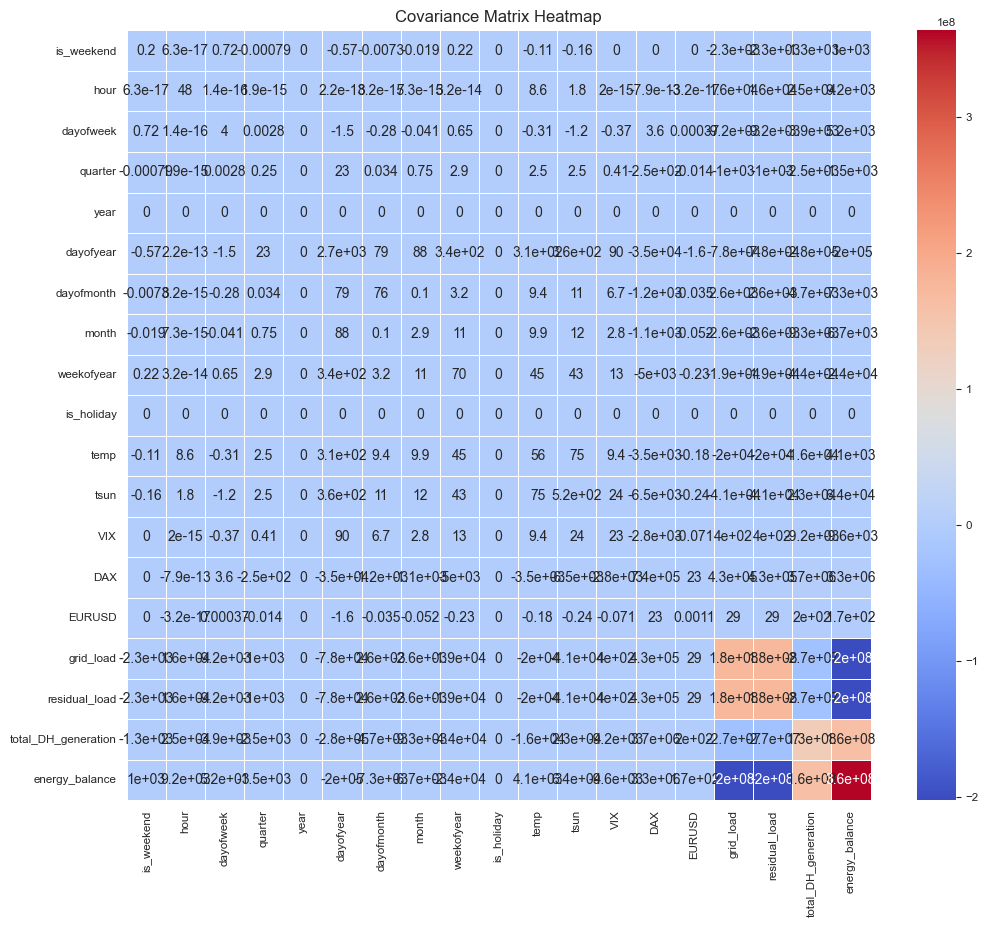

In [73]:
plt.figure(figsize=(12, 10))
sns.heatmap(
            xgb_merged_data.reset_index(drop=True).drop(
                ['price', 'datetime'],
                axis=1
                ).cov(),
            annot=True,
            cmap='coolwarm',
            linewidths=0.5
            )
plt.title('Covariance Matrix Heatmap')
plt.show()

From the table above, we can see that energy balance while having high variance has also non-trivial covariance with features related to the energy load. This was to be expected as it was merely the difference between DA generation and grid load. Between grid load and residual load, it also espected they have some correlation by definition.

We will use XGBoost feature later to see which features are the most important

In [74]:
drop_col = [
            # 'price_ma_3d',
            # 'temp',
            # 'EURUSD',
            'quarter',
            # 'is_weekend',
            # 'is_holiday',
            ]

cleaned_merged_data = xgb_merged_data.copy().drop(drop_col, axis=1)


#### **Run XGBoost**

In [75]:
split_date = datetime(2022, 5, 1)
xgb_obj = XGBWrapper(cleaned_merged_data, split_point=split_date)

Train-Test split at 2022-05-01 00:00:00


#### **Addding lagged target variables as features**

Time series data often has autocorrelation, meaning past values can provide useful information about future values. So we want to also include the previous lagged price data into our feature. However, to prevent leakage, we will also add this column after train-text data has been split.

Here we will use 1,2,3 lagged variable and rolling mean as from PACF graph suggested, this was appropriate.

In [76]:
xgb_obj.add_lagged_MA_price(3)

Adding 1-lagged hour of price to X_train and X_test
Adding mean of previous 2 hours of price to X_train and X_test
Adding mean of previous 3 hours of price to X_train and X_test


XGBoost model fitted.


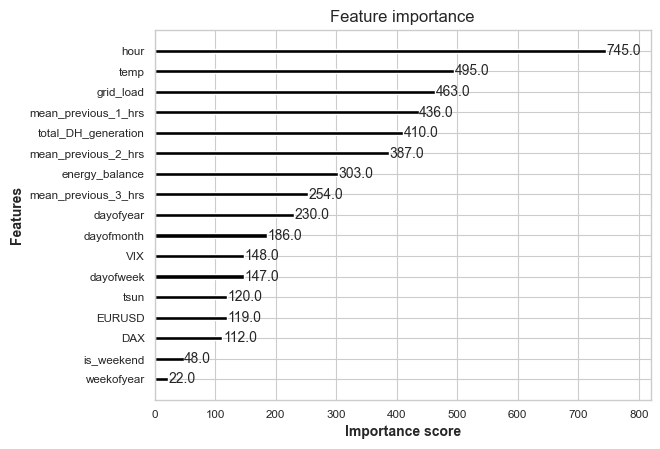

In [77]:
xgb_obj.run_xgb()
xgb_obj.plot_importance

In [78]:
xgb_obj.get_forecast()
xgb_obj.plot_forecast()
forecast_metric_long['XGBoost'] = list(xgb_obj.get_rmse_mae())

RSME for XGBoost: 21.26
MAE for XGBoost: 15.331


#### **Note**

Unlike ARIMA or Prophet, where longer forecast window did not perform well, XGBoost allows for decent longer term forcasting given the long historical data and features it has. We will use this to evaluate the performance of the shorter window, i.e. the last 24H and compare the the RMSE and MAE.

In [79]:
xgb_rsme_24H, xgb_mae_24H = du.get_rmse_mae(
                                xgb_obj.y_test[-24:],
                                xgb_obj.get_forecast_df['price_prediction'][-24:]
                                )

forecast_metric_short['XGBoost'] = [xgb_rsme_24H, xgb_mae_24H]

print(f"RMSE for XGBoost last 24 H: {xgb_rsme_24H}")
print(f"MAE for XGBoost last 24 H: {xgb_mae_24H}")

RMSE for XGBoost last 24 H: 28.487
MAE for XGBoost last 24 H: 19.508


<a id="0"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Q1 Analysis Conclusion</p>

A common method to evaluate the performance of forecasting models is to look at the error metrics, RMSE and MAE. Denote $y_i$ and $\hat{y}_i$ as the target and predicated value, here it the DAA price and predicted DAA price, where $i \in \{1,\dots,N\}$. Then, RSME and MAE are defined as:

-  Root Mean Squared Error (RMSE)
$$
\text{RMSE} = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} \left( y_i - \hat{y}_i \right)^2 }.
$$

RMSE gives more weight to larger errors, so it's more sensitive to outliers in the data.


- Mean Absolute Error (MAE)
$$
\text{MAE} = \frac{1}{N} \sum_{i=1}^{N} \left| y_i - \hat{y}_i \right|
$$
MAE is easy to interpret and treats all errors equally, regardless of their magnitude.

Rule of thumb is, we want the smaller values of RSME and/or MAE and these values. As sanity check, these values should be lower than the mean and std of the time series.

Now, let's look at the RSME and MAE of the models


In [80]:
du.print_rmse_mae_table(forecast_metric_long, "RMSE and MAE table for Models - Complete Evaluation, split at 2022-05-01")
du.print_rmse_mae_table(forecast_metric_short, "RMSE and MAE table for Models - 24H Evaluation")

RMSE and MAE table for Models - Complete Evaluation, split at 2022-05-01
+---------+----------+----------+
| Model   |     RMSE |      MAE |
+=========+==========+==========+
| ARIMA   |  80.867  |  65.13   |
+---------+----------+----------+
| Prophet | 139.455  | 114.839  |
+---------+----------+----------+
| XGBoost |  21.2596 |  15.3306 |
+---------+----------+----------+
------------------------------------------------------------
RMSE and MAE table for Models - 24H Evaluation
+---------+--------+--------+
| Model   |   RMSE |    MAE |
+=========+========+========+
| ARIMA   | 68.445 | 57.871 |
+---------+--------+--------+
| Prophet | 39.688 | 30.529 |
+---------+--------+--------+
| XGBoost | 28.487 | 19.508 |
+---------+--------+--------+
------------------------------------------------------------


As shown in the table generated above, XGBoost demonstrates the lowest overall RMSE and MAE, outperforming both ARIMA and Prophet, in longer and shorter forecast window.

This is expected as XGBoost used more feature engineering and ARIMA & Prophet are univariate time series models. These traditional models struggle with long-term forecasting, with Prophet performing worst amongst the 3 models. However, when the training and testing window is shortened, both ARIMA and Prophet show improved RMSE and MAE values—though still not as low as those achieved by XGBoost.

In terms of runtime, the difference seems to be insignificant given the data we obtained. However, a caveat for ARIMA is that the ACF plot does not give a clear picture of what parameters to be picked in ARIMA($p,d,q$). Therefore, an optimization was carried out to find the optimized $(p,d,q)$. This can be time consuming.

Therefore, as XGBoost performs the best here, we will <span style="color:rgb(17, 142, 6);">**choose XGBoost**</span> going forward.

### <span style="color: #F8766D;">**Limitations and Improvements**</span>

One way to improve the analysis is by incorporating backtesting. Backtesting simulates how a forecasting model would have performed in the past by repeatedly training and testing it on different rolling windows of historical data. 

This helps assess the model’s stability and generalization across time. Implementation typically includes splitting the dataset into multiple train-test splits, sliding the window forward for time series, and keep forecasting metrics at each step. 

Another potential model that can be considered in the future is the use of neural network such as Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks, which are designed to handle sequential data by maintaining information over time steps. However, they also have limitation in a way that the global minima might not be reached or the runtime would take too long for larger data.

In [81]:
# pickle dump fitted XGBoost for forcasting short window (24H)
with open('xgb_model_fitted.pkl', 'wb') as f:
    pickle.dump(xgb_obj.model, f)

In [82]:
xgb_obj.predicted_XGBoost.to_csv('./data/xgb_forecasted_price.csv')

<a id="0"></a>
<p style="background-color:#ff7f51;font-family:Trebuchet MS;font-weight:bold;color:#FFFFFF ;font-size:40px;text-align:center;border-radius:100px 100px">Question 2</p>

